# Summary

In [1]:
%load_ext autoreload

import os
import numpy as np
import scipy.io as sio

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import zscore

import flygenvectors.plotting as plotting
import flygenvectors.utils as utils
import flygenvectors.ssmutils as ssmutils
import flygenvectors.data as dataUtils
from flygenvectors.dlc import DLCLabels

In [2]:
plot_dark = False

sns.set_context('talk')
if plot_dark:
    plt.style.use('dark_background')
#     cmap_rasters = 'inferno'
    cmap_rasters = 'afmhot'
else:
    sns.set_style('white')
    cmap_rasters = 'Greys'

# 1. Load and preprocess data

In [3]:
# options
# expt_id = '190424_f3'  # (run+feed)
# expt_id = '180824_f3r1'
# expt_id = '2019_06_26_fly2'
# expt_id = '2019_06_28_fly2'
# expt_id = '2019_06_30_fly1'
expt_id = '2019_07_01_fly2'

# preprocessing directives
preprocess_list = {
    #'interpolate_labels': {'thresh': 0.8, 'window': 3}, # "bad" labels replaced with avg of neighboring "good" labels
    # 'standardize': {}, # zscore labels
    'unitize': {}, # scale labels in [0, 1]
    #'filter': {'type': 'median', 'window_size': 3},
    #'filter': {'type': 'savgol', 'window_size': 5, 'order': 2},
    #'remove_bad_runs': {'thresh': 0.8, 'min_length': 10} # remove runs where at least one label is "bad"
}
do_fit_differences = False  # fit label differences rather than original labels

# load and preprocess dlc labels
dlc_obj = DLCLabels(expt_id, algo='dgp')
# dlc_obj.load_from_csv()
dlc_obj.load_from_mat()
dlc_obj.preprocess(preprocess_list)

# split labels into train/test/val
# dlc_obj.extract_runs_by_likelihood(
#     likelihoods=dlc_obj.labels['l'], l_thresh=0.0, min_length=100, max_length=500, 
#     skip_idxs=dlc_obj.skip_idxs)
dlc_obj.extract_runs_by_length(max_length=1000)
dlc_obj.split_labels(
    dtypes=['train', 'test', 'val'], dtype_lens=[9, 0, 1], diff=do_fit_differences)

# define model dir based on preprocessing
model_dir = 'dlc-arhmm'
if 'filter' in preprocess_list.keys():
    if preprocess_list['filter']['type'] == 'median':
        model_dir += '-median-%i' % preprocess_list['filter']['window_size']
    elif preprocess_list['filter']['type'] == 'savgol':
        model_dir += '-savgol-%i-%i' % (
            preprocess_list['filter']['window_size'], preprocess_list['filter']['order'])
    else: 
        raise NotImplementedError
if do_fit_differences:
    model_dir += '-diff'
print('\nsaving models in the following directory: "%s"' % model_dir)

loading labels from /media/mattw/data/flygenvectors/2019_07_01_fly2/crops_labels...done
total time points: 192980
unitizing labels...done
extracting runs of length 1000...done
extracted 193 runs for a total of 192980 time points
splitting labels into ['train', 'test', 'val']...done
	train: 173980 time points in 174 trials
	test: 0 time points in 0 trials
	val: 19000 time points in 19 trials

saving models in the following directory: "dlc-arhmm"


### check outliers

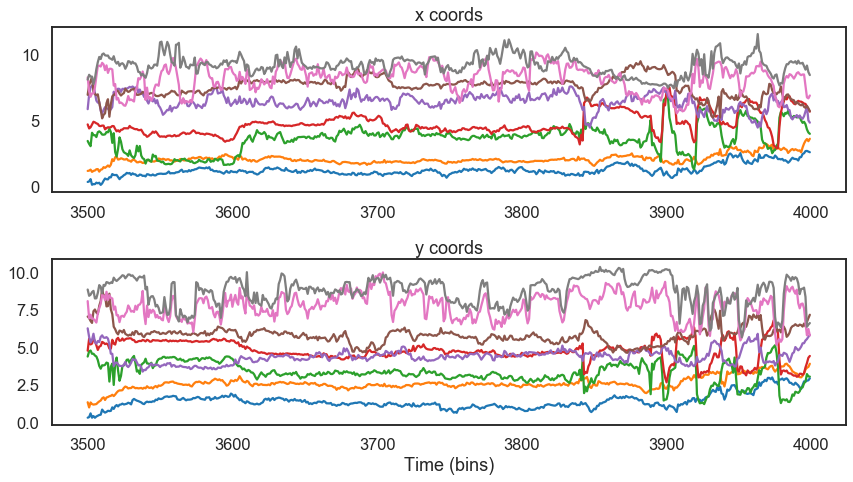

In [4]:
# plot dlc labels/likelihoods over time
slc = (3500, 4000)
plot_diffs = False
frac = 10 

plt.figure(figsize=(12, 10))

# plt.subplot(311)
# plt.plot(np.arange(slc[0], slc[1]), dlc_obj.labels['l'][slice(*slc), :])
# plt.title('likelihoods')

plt.subplot(312)
coord = 'x'
behavior = frac * dlc_obj.labels[coord] / np.max(np.abs(dlc_obj.labels[coord])) + \
    np.arange(dlc_obj.labels[coord].shape[1])
if plot_diffs:
    behavior = np.concatenate(
        [np.zeros(shape=(1, behavior.shape[1])), np.diff(behavior, axis=0)])
plt.plot(np.arange(slc[0], slc[1]), behavior[slice(*slc), :])
plt.title('%s coords' % coord)

plt.subplot(313)
coord = 'y'
behavior = frac * dlc_obj.labels[coord] / np.max(np.abs(dlc_obj.labels[coord])) + \
    np.arange(dlc_obj.labels[coord].shape[1])
if plot_diffs:
    behavior = np.concatenate(
        [np.zeros(shape=(1, behavior.shape[1])), np.diff(behavior, axis=0)])
plt.plot(np.arange(slc[0], slc[1]), behavior[slice(*slc), :])
plt.title('%s coords' % coord)

plt.xlabel('Time (bins)')
plt.tight_layout()
plt.show()

# 2. Fit dynamics

### ARHMM - how many discrete states?

In [ ]:
%autoreload 2
import flygenvectors.ssmutils as ssmutils

# hyperparams that are same across all models
observations = 'diagonal_robust_ar'
# observations = 'diagonal_ar' #'ar'
# init_type = 'kmeans'
init_type = 'arhmm'

# params that define models
n_states = [2, 4, 6, 8, 10, 12, 16, 20]
# n_states = [32, 48]
n_lags_standard = []
n_lags_sticky = [4]
kappas = [1e4, 1e6]

model_kwargs = {}
# model_kwargs['hmm'] = {
#     'transitions': 'standard', 
#     'observations': 'gaussian'}
# add models with standard transitions
for lags in n_lags_standard:
    model_kwargs['arhmm-%i' % lags] = {
        'transitions': 'standard', 
        'observations': observations,
        'observation_kwargs': {'lags': lags}}
# add models with sticky transitions
for lags in n_lags_sticky:
    for kappa in kappas:
        kap = int(np.log10(kappa))
        model_kwargs['arhmm-s%i-%i' % (kap, lags)] = {
            'transitions': 'sticky', 
            'transition_kwargs': {'kappa': kappa},
            'observations': observations,
            'observation_kwargs': {'lags': lags}}

if init_type == 'arhmm':
    model_dir_ext = model_dir + '-2-state-init'
else:
    model_dir_ext = model_dir
    
fit_kwargs = {
    'save': True,
    'load_if_exists': True,
    'expt_id': expt_id,
    'model_dir': model_dir_ext,
    'save_dir': None}
    
D = dlc_obj.labels_dict['train'][0].shape[1]
all_results = {}
# iterate over model types
for model_name, kwargs in model_kwargs.items():
#     if model_name in all_results and len(all_results[model_name] == n_states):
#         continue
    model_results = {}
    # iterate over discrete states
    for K in n_states:
        if model_name == 'arhmm-s6-3' and K == 48:
            continue
        print('Fitting %s with %i states' % (model_name, K))
        model_results[K] = ssmutils.fit_model(
            n_states=K, data_dim=D, input_dim=0, model_kwargs=kwargs,
            data_tr=dlc_obj.labels_dict['train'], 
            data_val=dlc_obj.labels_dict['val'],
            data_test=dlc_obj.labels_dict['test'],
            init_type=init_type, fit_kwargs=fit_kwargs)
    all_results[model_name] = model_results

Fitting arhmm-s4-4 with 2 states


saving model to /home/mattw/results/fly/2019_07_01_fly2/dlc-arhmm-2-state-init/obs=diagonal_robust_ar_trans=sticky_lags=4_K=02_kappa=1e+04.pkl
Fitting arhmm-s4-4 with 4 states


saving model to /home/mattw/results/fly/2019_07_01_fly2/dlc-arhmm-2-state-init/obs=diagonal_robust_ar_trans=sticky_lags=4_K=04_kappa=1e+04.pkl
Fitting arhmm-s4-4 with 6 states


saving model to /home/mattw/results/fly/2019_07_01_fly2/dlc-arhmm-2-state-init/obs=diagonal_robust_ar_trans=sticky_lags=4_K=06_kappa=1e+04.pkl
Fitting arhmm-s4-4 with 8 states


saving model to /home/mattw/results/fly/2019_07_01_fly2/dlc-arhmm-2-state-init/obs=diagonal_robust_ar_trans=sticky_lags=4_K=08_kappa=1e+04.pkl
Fitting arhmm-s4-4 with 10 states


saving model to /home/mattw/results/fly/2019_07_01_fly2/dlc-arhmm-2-state-init/obs=diagonal_robust_ar_trans=sticky_lags=4_K=10_kappa=1e+04.pkl
Fitting arhmm-s4-4 with 12 states


saving model to /home/mattw/results/fly/2019_07_01_fly2/dlc-arhmm-2-state-init/obs=diagonal_robust_ar_trans=sticky_lags=4_K=12_kappa=1e+04.pkl
Fitting arhmm-s4-4 with 16 states


saving model to /home/mattw/results/fly/2019_07_01_fly2/dlc-arhmm-2-state-init/obs=diagonal_robust_ar_trans=sticky_lags=4_K=16_kappa=1e+04.pkl
Fitting arhmm-s4-4 with 20 states


saving model to /home/mattw/results/fly/2019_07_01_fly2/dlc-arhmm-2-state-init/obs=diagonal_robust_ar_trans=sticky_lags=4_K=20_kappa=1e+04.pkl
Fitting arhmm-s6-4 with 2 states


saving model to /home/mattw/results/fly/2019_07_01_fly2/dlc-arhmm-2-state-init/obs=diagonal_robust_ar_trans=sticky_lags=4_K=02_kappa=1e+06.pkl
Fitting arhmm-s6-4 with 4 states


saving model to /home/mattw/results/fly/2019_07_01_fly2/dlc-arhmm-2-state-init/obs=diagonal_robust_ar_trans=sticky_lags=4_K=04_kappa=1e+06.pkl
Fitting arhmm-s6-4 with 6 states


saving model to /home/mattw/results/fly/2019_07_01_fly2/dlc-arhmm-2-state-init/obs=diagonal_robust_ar_trans=sticky_lags=4_K=06_kappa=1e+06.pkl
Fitting arhmm-s6-4 with 8 states


saving model to /home/mattw/results/fly/2019_07_01_fly2/dlc-arhmm-2-state-init/obs=diagonal_robust_ar_trans=sticky_lags=4_K=08_kappa=1e+06.pkl
Fitting arhmm-s6-4 with 10 states


saving model to /home/mattw/results/fly/2019_07_01_fly2/dlc-arhmm-2-state-init/obs=diagonal_robust_ar_trans=sticky_lags=4_K=10_kappa=1e+06.pkl
Fitting arhmm-s6-4 with 12 states


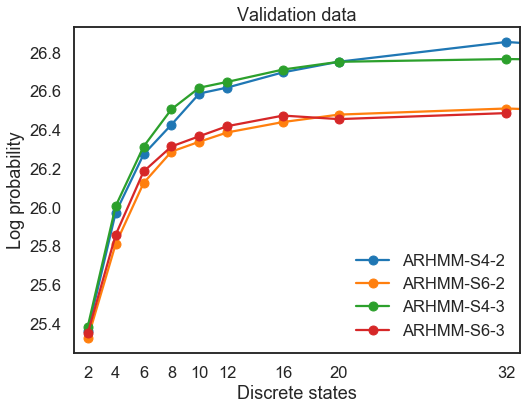

In [18]:
fig = plotting.plot_validation_likelihoods(
    all_results=all_results, 
    T_val=np.sum([d.shape[0] for d in dlc_obj.labels_dict['val']]))

In [15]:
# compute likelihood of viterbi path
for model_name, model_results in all_results.items():
    for K in model_results.keys():
        model_results[K]['ll_val_viterbi'] = ssmutils.viterbi_ll(
            model_results[K]['model'], dlc_obj.labels_dict['val'])

(1, 49)

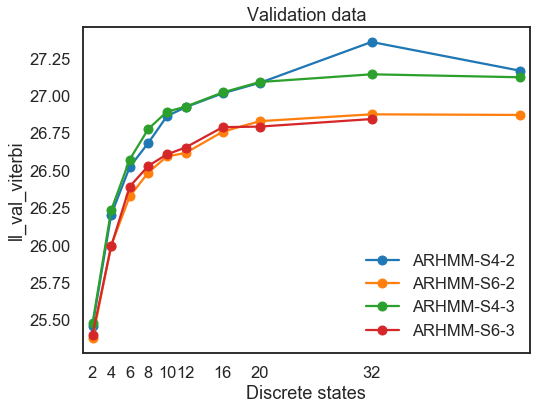

In [17]:
fig = plotting.plot_validation_likelihoods(
    all_results=all_results, 
    T_val=np.sum([d.shape[0] for d in dlc_obj.labels_dict['val']]),
    dict_key='ll_val_viterbi')

# 3. Probe learned dynamics

In [9]:
# choose model
K = 20
n_lags = 2
model_name = str('arhmm-s4-%i' % n_lags)
dtype = 'train'
arhmm = all_results[model_name][K]['model']
# get most likely states
states_all = [arhmm.most_likely_states(d) for d in dlc_obj.labels_dict[dtype]]

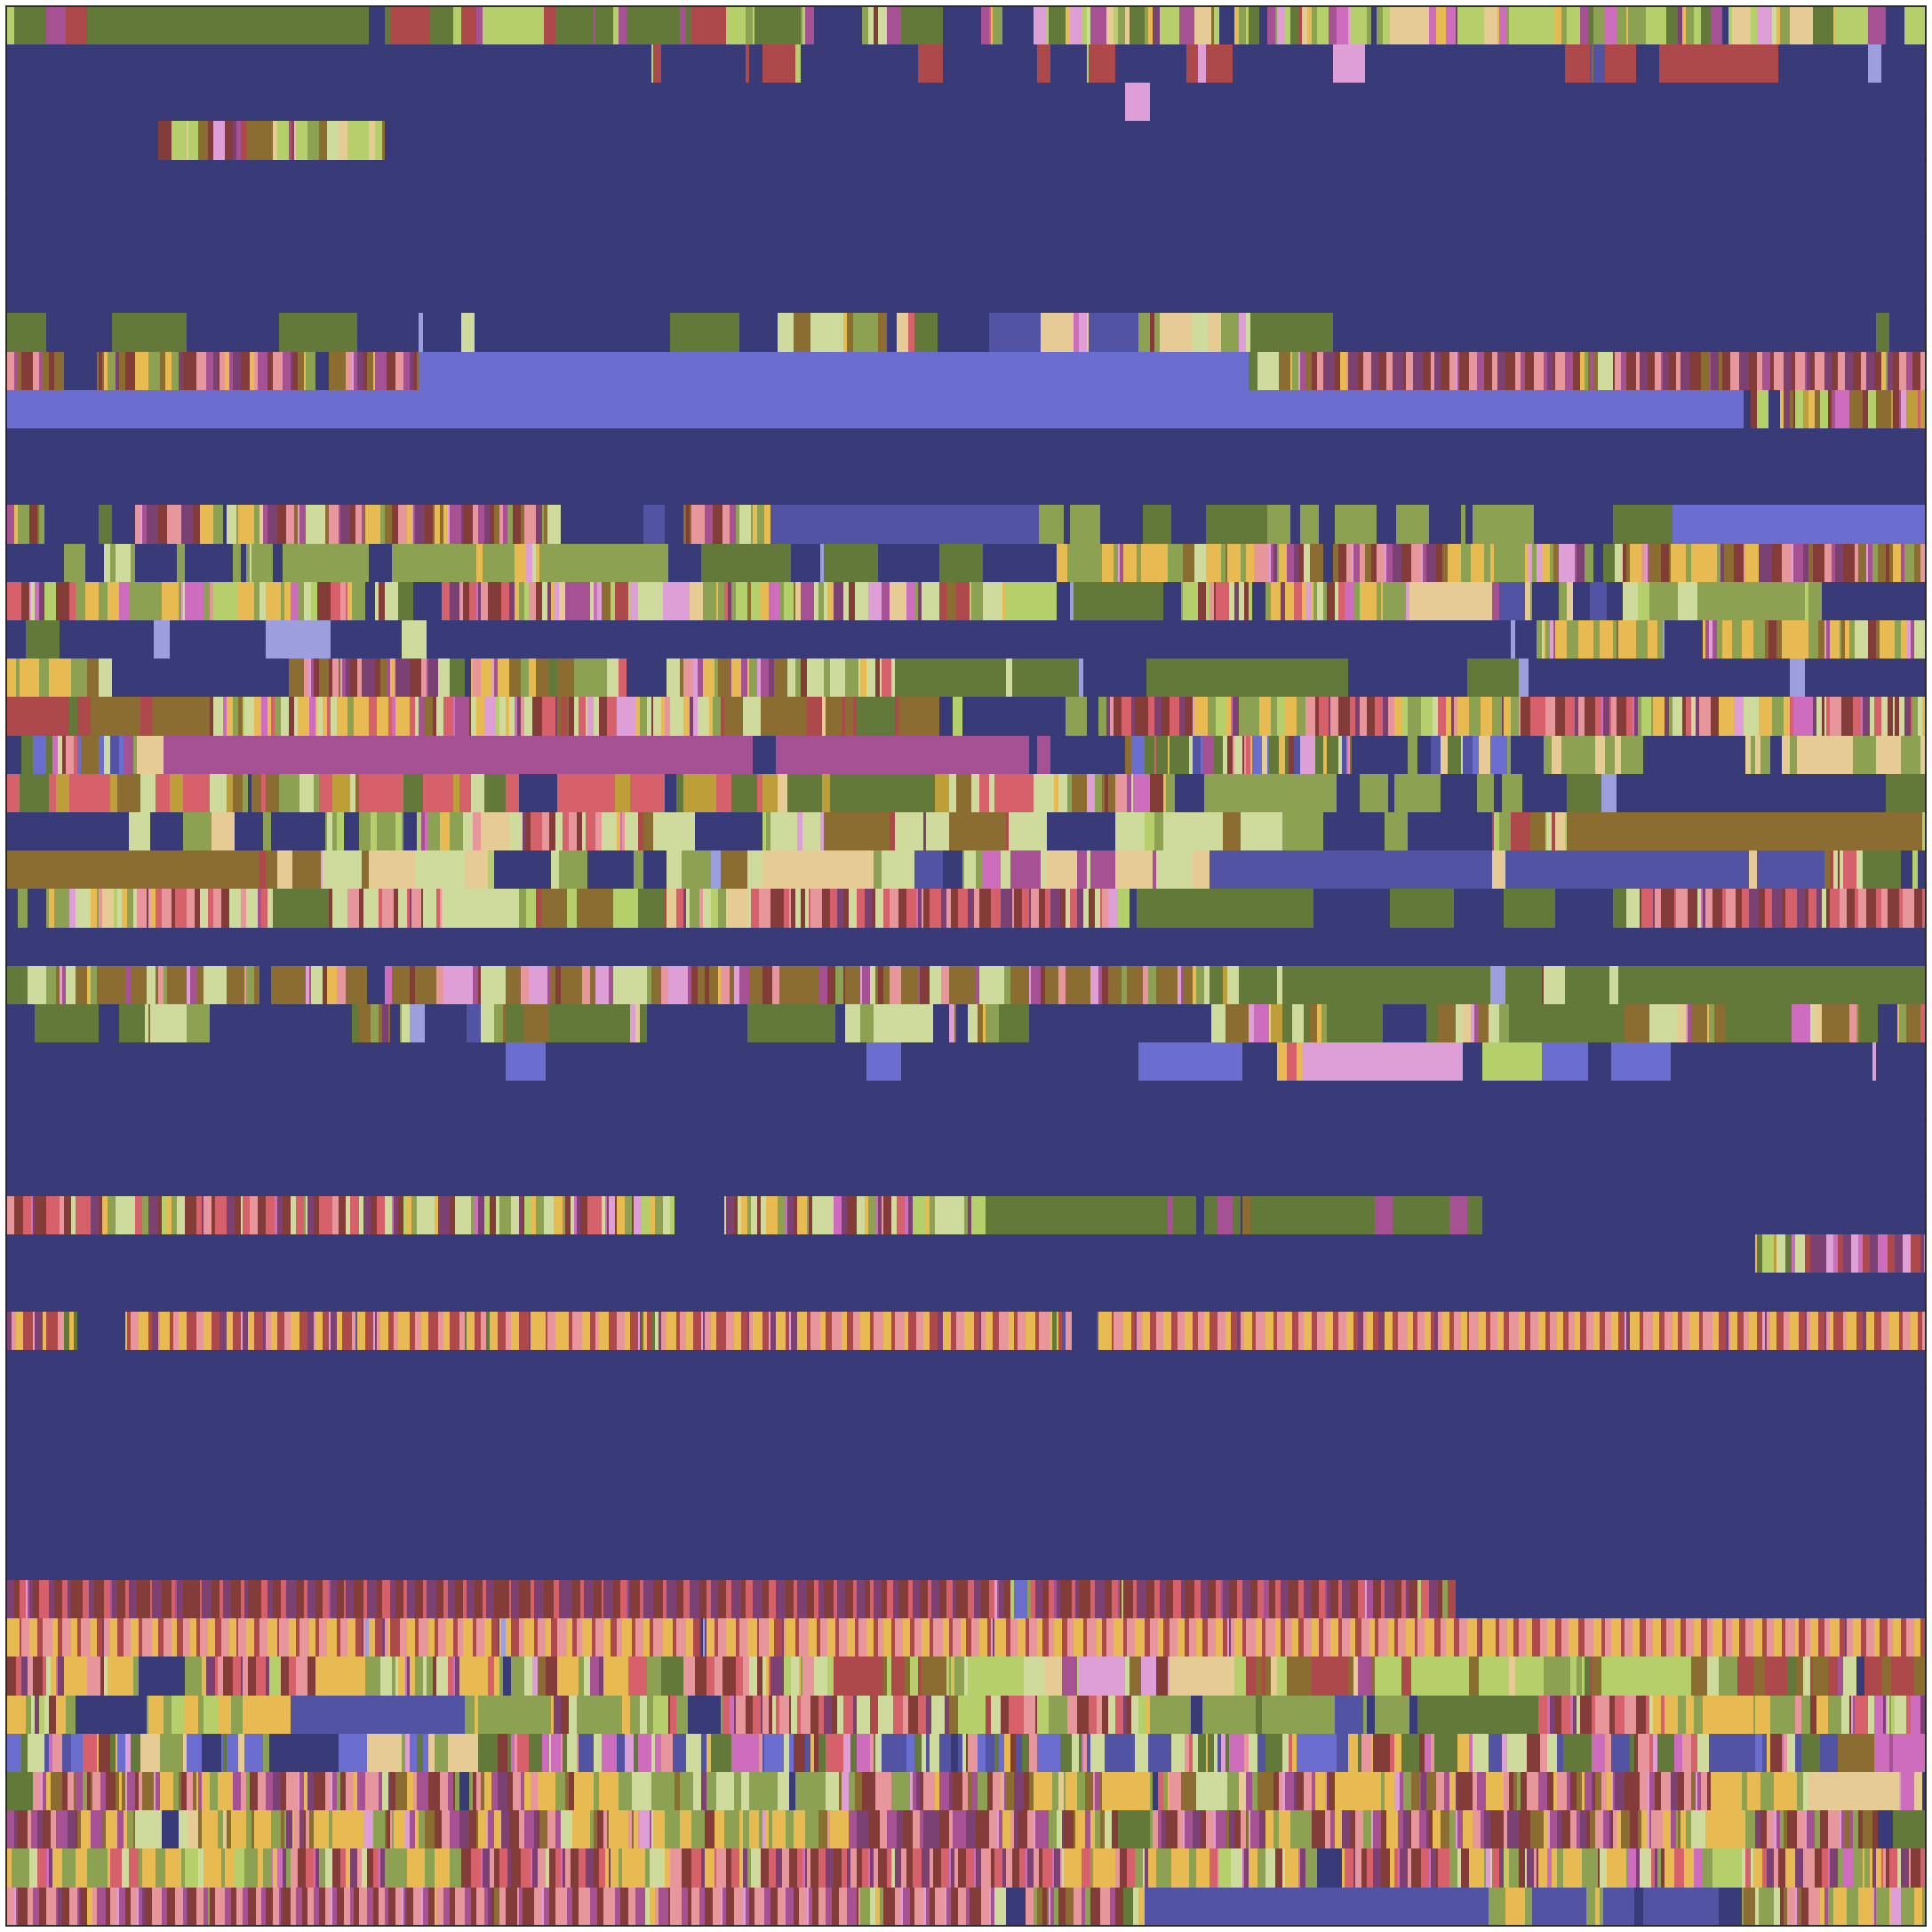

In [10]:
# plot all training trials
mult = 50
fig, axes = plt.subplots(mult, 1, figsize=(30, 0.6 * mult))
for i, ax in enumerate(axes):
    ax.imshow(states_all[i][None, :], aspect='auto', cmap='tab20b')
    ax.set_xticks([]); ax.set_yticks([])
    if not ax.is_first_row():
        ax.spines['top'].set_visible(False)
    if not ax.is_last_row():
        ax.spines['bottom'].set_visible(False)
plt.tight_layout(pad=0)

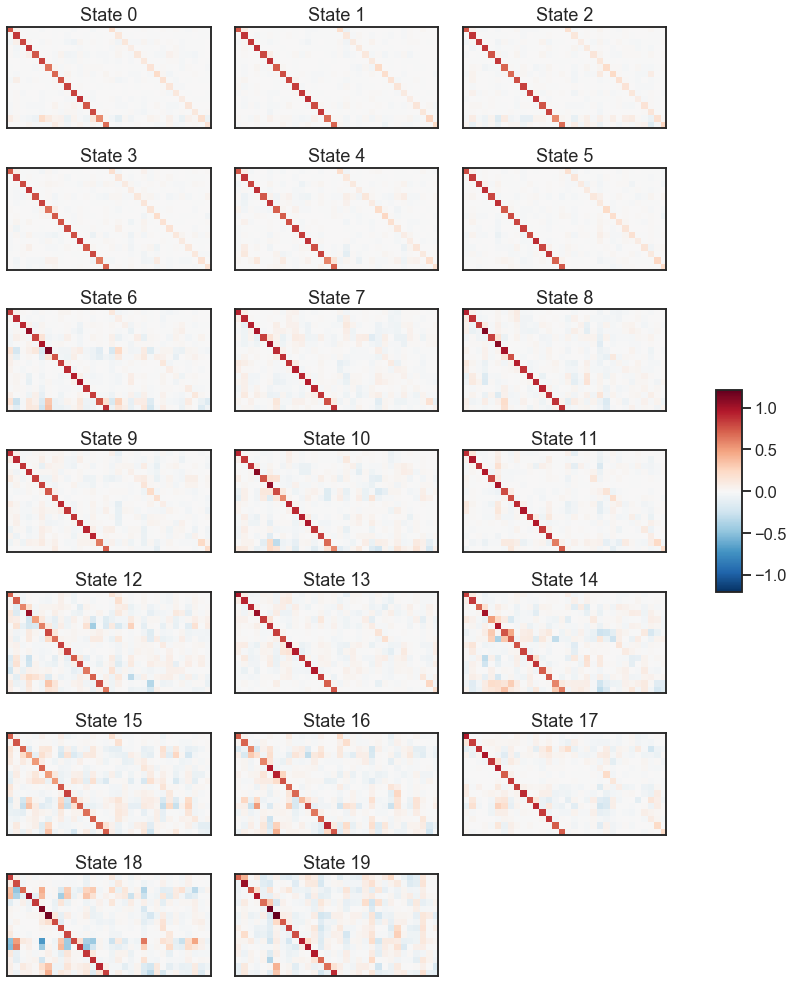

In [11]:
%autoreload
fig = plotting.plot_dynamics_matrices(arhmm, deridge=False)

In [ ]:
fig = plotting.plot_covariance_matrices(arhmm)

In [ ]:
fig = plotting.plot_biases(arhmm)

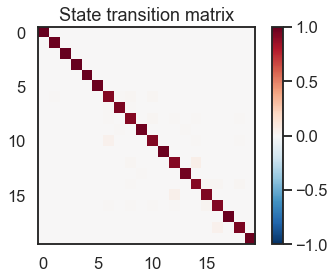

In [12]:
fig = plotting.plot_state_transition_matrix(arhmm)

### find multiple snippets of validation data for each state

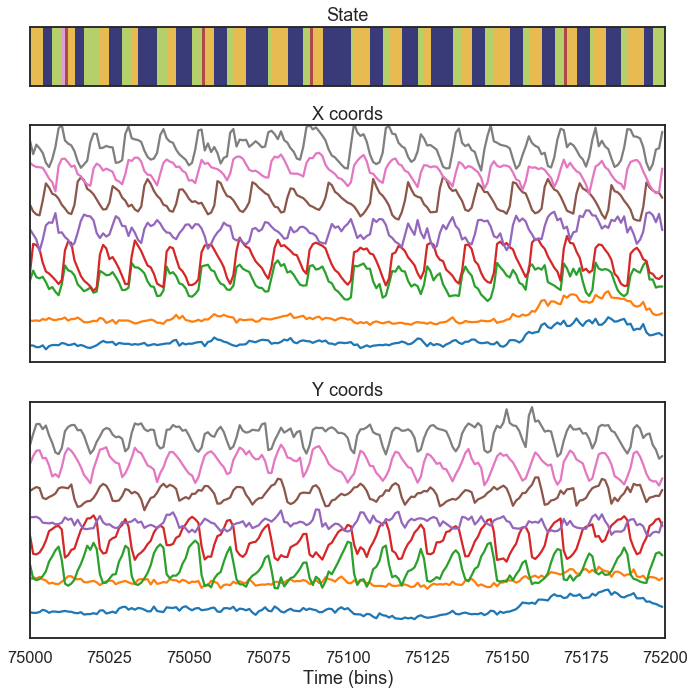

In [13]:
# infer all states and plot dlc lablels
states_ = arhmm.most_likely_states(dlc_obj.get_label_array())
slc = (75000, 75200)
fig = plotting.plot_dlc_arhmm_states(
    dlc_labels=dlc_obj.labels, state_probs=None, states=states_, slc=slc, m=5)

In [ ]:
# import pickle
# data = {
#     'states_train': [arhmm.most_likely_states(d) for d in dlc_obj.labels_dict['train']],
#     'states_val': [arhmm.most_likely_states(d) for d in dlc_obj.labels_dict['val']],
#     'idxs_train': dlc_obj.idxs_dict['train'],
#     'idxs_val': dlc_obj.idxs_dict['val']}
# with open('/home/mattw/results/fly/arhmm_dlc_states.pkl', 'wb') as f:
#     pickle.dump(data, f)

In [15]:
# collect all state snippets
indx_snippets = ssmutils.extract_state_runs(
    states_all, dlc_obj.idxs_dict[dtype], min_length=2)

# get dlc labels
dlc_snippets = [{'x': [], 'y': []} for _ in range(K)]
state_lengths = [[] for _ in range(K)]
for k, k_indxs in enumerate(indx_snippets):
    for k_indx in k_indxs:
        state_lengths[k].append(len(k_indx))
        for coord in ['x', 'y']:
            dlc_snippets[k][coord].append(dlc_obj.labels[coord][k_indx])        
state_lengths = [np.array(state_lengths[k]) for k in range(K)]

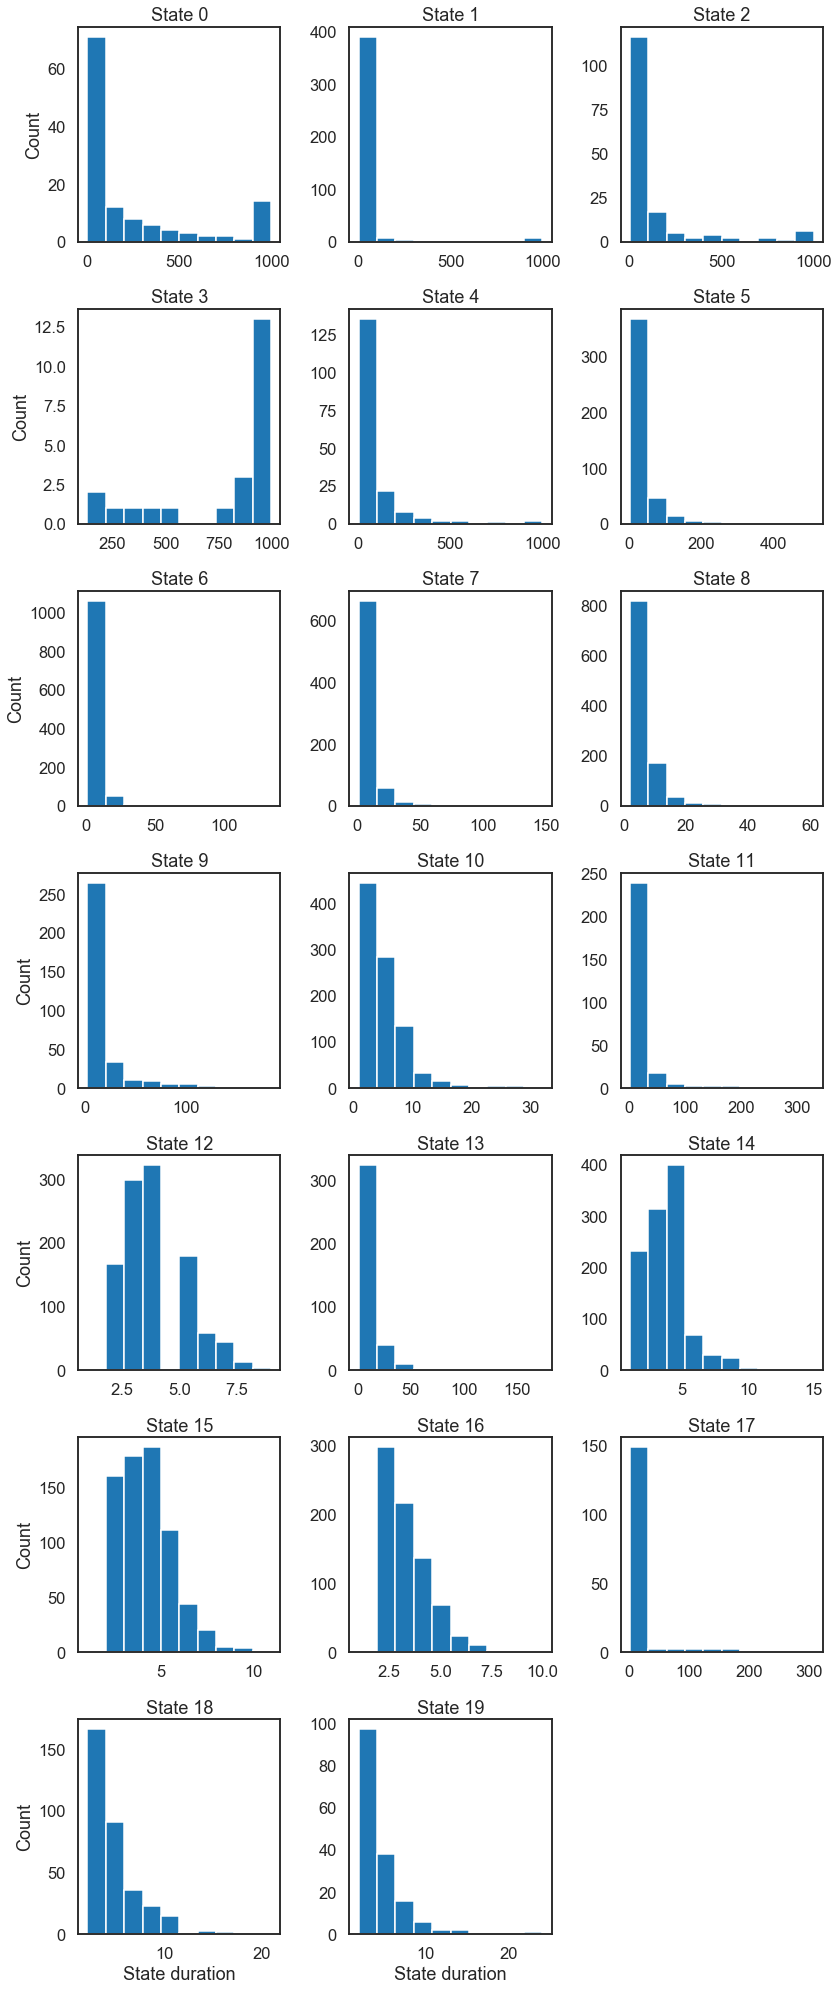

In [16]:
# plot distribution of state durations
n_cols = 3
n_rows = np.ceil(K / n_cols)

fig = plt.figure(figsize=(4 * n_cols, 4 * n_rows))

for i, slens in enumerate(state_lengths):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.hist(slens) #, range=(0, 100))
    plt.title(str('State %i' % i))
    if plt.gca().is_first_col():
        plt.ylabel('Count')
    if plt.gca().is_last_row():
        plt.xlabel('State duration')
plt.tight_layout()
plt.show()

### check for state consistency across lags

In [ ]:
# K = 12
# dtype = 'train'
# lags = [1, 2, 3, 5]
# states_ = {l:None for l in lags}

# for lag in lags:
#     if lag == 1:
#         model_name = 'arhmm'
#     else:
#         model_name = str('arhmm-%i' % lag)
#     arhmm = all_results[model_name][K]['model']
#     states_[lag] = arhmm.most_likely_states(dlc_array)

In [ ]:
# slc = (75000, 75200)

# fig, axes = plt.subplots(
#     len(lags), 1, figsize=(10, 1.5 * len(lags)),
#     gridspec_kw={'height_ratios': [1 / len(lags)] * len(lags)})

# for i, l in enumerate(lags):
#     axes[i].imshow(states_[l][None, slice(*slc)], aspect='auto', cmap='tab20b')
#     axes[i].set_xticks([])
#     axes[i].set_yticks([])
#     axes[i].set_ylabel('%i lags' % l)
# plt.tight_layout()
# plt.show()

In [ ]:
# %autoreload 2
fig = plotting.make_syllable_plots(
    dlc_snippets, max_snippets=5, max_t=100, coord='y', states_to_plot=[7, 8])